[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM.git/master?filepath=PySDM_examples/Shima_et_al_2009_Fig_2/demo.ipynb)    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM/blob/master/PySDM_examples/Shima_et_al_2009_Fig_2/demo.ipynb)

#### based on Fig. 2 from Shima et al. 2009 (Q. J. R. Meteorol. Soc. 135)  "_The super‐droplet method for the numerical simulation of clouds and precipitation: a particle‐based and probabilistic microphysics model coupled with a non‐hydrostatic model_"   
https://doi.org/10.1002/qj.441

In [1]:
"""
clone and install PySDM dependencies in Colab
(to use GPU on Colab set hardware accelerator to 'GPU' before session start
in the "Runtime :: Change runtime type :: Hardware accelerator" menu)
"""
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PySDM'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PySDM.git
        %cd PySDM
    else:
        %cd PySDM
        !git pull
    !pip --quiet install --requirement requirements.txt
    !ldconfig

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PySDM
else:
    sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
from numpy import errstate
from PySDM.backends import CPU, GPU
from PySDM_examples.Shima_et_al_2009_Fig_2.spectrum_plotter import SpectrumPlotter
from PySDM_examples.Shima_et_al_2009_Fig_2.settings import Settings
from PySDM_examples.Shima_et_al_2009_Fig_2.example import run
from PySDM_examples.utils import widgets

In [4]:
progbar = widgets.IntProgress(min=0, max=100, description='%')
class ProgbarUpdater:
    def __init__(self, progbar, max_steps):
        self.max_steps = max_steps
        self.steps = 0
        self.progbar = progbar

    def notify(self):
        self.steps += 1
        self.progbar.value = 100 * (self.steps / self.max_steps)

In [5]:
def demo(*, n_SD, n_step, n_plot, adaptive, smooth, gpu):
    with errstate(all='raise'):
        settings = Settings()
        backend = GPU if gpu else CPU
        settings.n_sd = 2 ** n_SD
        settings.adaptive = adaptive
        settings.dt = 10 if adaptive else settings.dt
        settings._steps = [i * (n_step // n_plot) for i in range(n_plot + 1)]
        
        states, _ = run(settings, backend, (ProgbarUpdater(progbar, settings.steps[-1]),))
    
    with errstate(invalid='ignore'):
        plotter = SpectrumPlotter(settings)
        plotter.smooth = smooth
        for step, state in states.items():
            plotter.plot(state, step * settings.dt)
        plotter.show()

IntProgress(value=100, description='%')

Output()

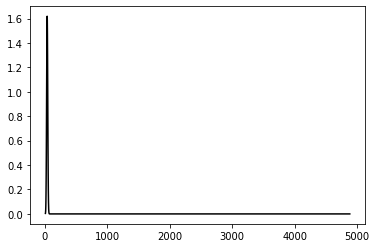

In [6]:
n_SD = widgets.IntSlider(value=14, min=12, max=18, step=1, description='$log_2(n_{SD})$', continuous_update=False)
n_step = widgets.IntSlider(value=3600, step=100, min=0, max=3600, description='$n_{step}$', continuous_update=False)
n_plot = widgets.IntSlider(value=3, step=1, min=1, max=8, description='$n_{plot}$', continuous_update=False)
sliders = widgets.HBox([n_SD, n_step, n_plot])

adaptive = widgets.Checkbox(value=False, description='adaptive dt')
smooth = widgets.Checkbox(value=True, description='smooth plot')
gpu = widgets.Checkbox(value=False, description='GPU')
options = [adaptive, smooth]
if GPU.ENABLE:
    options.append(gpu)
boxes = widgets.HBox(options)
# TODO: freezer
self = widgets.interactive_output(demo, 
                                  {'n_SD': n_SD, 'n_step': n_step, 'n_plot': n_plot, 'adaptive': adaptive, 'smooth': smooth, 'gpu': gpu})

display(sliders, boxes, progbar, self)